# 05/22/23 - This notebook is copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/kinematics_maps/plot_kinematics_contours/plot_kinematics_contours_V_VD_bspline_models_margin_gnog_050823.ipynb
## See https://docs.google.com/spreadsheets/d/141wpCILejD7JhJdo5OuwJAY6xN7B-lNpK36Gbvr8o4k/edit#gid=1171125292&range=B478
## I should have set the photometry up to convert to B-band instead of I-band for F435W
# 05/30/23 - Updating to do the other objects besides J0037... starting with J1621
# 05/31/23 - Updating correct photometry practices... See emails with Tommaso. 
https://mail.google.com/mail/u/0/?tab=rm&ogbl#inbox/QgrcJHsHpClsHsxLMLKBvnrXbjRmTmwFDTQ


In [130]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import plot_contours_531
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf
from slacs_mge_jampy import plot_kinematics_mge_contours
from slacs_mge_jampy import get_bin_centers
from slacs_mge_jampy import jampy_details

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC


In [131]:
# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2023-02-28_2'

###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2023-02-28_2/



In [132]:
# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapst 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff
        
def get_bins (file_dir, obj_name):
    
    scale=0.1457
    
    #######################################
    ## import voronoi binning data
    voronoi_binning_data = fits.getdata(file_dir +'voronoi_binning_' + obj_name + '_data.fits')
    vorbin_pixels = np.genfromtxt(f'{file_dir}voronoi_2d_binning_{obj_name}_output.txt',
                     delimiter='')
    # sort the voronoi bin pixel data by bin
    vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]
    
    ########################################
    # find bin centers
    xbin, ybin = get_bin_centers (vorbin_pixels, len(voronoi_binning_data))
    
     #######################################
    # Changes - 11/30/22
    #######################################

    # convert to arcsec # kcwi!
    xbin_arcsec = xbin * scale
    ybin_arcsec = ybin * scale

    return xbin_arcsec, ybin_arcsec

# 05/22/23 - Checking the conversion to magnitudes
# 06/01/23 - First with J0037

In [133]:
obj_names_index=1
obj_name = obj_names[obj_names_index]

print('#####################################################################################################################')
print('#####################################################################################################################')
print()
print(f'Beginning final kinematics visualization and plotting for object {obj_name}.')
print()

obj_abbr = obj_name[4:9] # e.g. J0029

    #------------------------------------------------------------------------------
# object-specific directories

mos_dir = f'{mosaics_dir}{obj_name}/' 
kin_dir = f'{kinematics_dir}{obj_name}/'

print('################################################')
print('Getting KCWI datacube')

kcwi_img, kcwi_5arc_img, kcwi_3arc_img, kcwi_header, \
    kcwi_central_pix_x, kcwi_central_pix_y, kcwi_pa = import_center_crop(data_dir, mos_dir, obj_name, obj_names_index, obj_abbr, 
                                                                          data_source='kcwi_datacube', plot=False)


hst_full_img, hst_5arc_img, hst_3arc_img, bspl_full_img, bspl_5arc_img, bspl_3arc_img, hst_header, \
    central_pix_x, central_pix_y, exp_time = import_center_crop(data_dir, hst_dir, obj_name, obj_names_index, obj_abbr, 
                                                      data_source='HST', plot=False)

    
file_m = glob.glob(f'{mos_dir}{obj_name}_mge_fit_sectors_regularized_model.pkl')
if file_m:
    print('mge model exists, loading...')
    with open(file_m[0], 'rb') as file:
        m = pickle.load(file)

    print('################################################')
    print('Regularized MGE fit')
    


#####################################################################################################################
#####################################################################################################################

Beginning final kinematics visualization and plotting for object SDSSJ0037-0942.

################################################
Getting KCWI datacube
mge model exists, loading...
################################################
Regularized MGE fit


In [134]:
paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')


# start with J0037
#obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
#obj_abbr = obj_name[4:9] # e.g. J0029
zlens = paper_table[paper_table['obj_name']==obj_name]['zlens'].to_numpy()[0] #zs[1]
ang_distance = cosmo.angular_diameter_distance(zlens).value
lum_distance = cosmo.luminosity_distance(zlens).value

mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
kin_dir = f'{kinematics_dir}{obj_name}/'
#jam_dir = f'{jam_output_dir}{obj_name}/'
# create a directory for JAM outputs
#Path(jam_dir).mkdir(parents=True, exist_ok=True)

# start with target sn of 15
SN = '15'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
#target_jam_dir = f'{jam_dir}target_sn_{SN}/'
# create a directory for JAM outputs
#Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

# take the surface density, etc from mge saved parameters
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
    tommy_pickles = pickle.load(f)


surf = tommy_pickles.surf_density
sigma = tommy_pickles.mge_sigma
qObs = tommy_pickles.q
kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
Vrms_bin = tommy_pickles.Vrms_bin
dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
V_bin = tommy_pickles.V_bin
dV_bin = tommy_pickles.dV_bin
xbin_phot = tommy_pickles.xbin_phot
ybin_phot = tommy_pickles.ybin_phot
reff = tommy_pickles.reff


axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
pa_phot = axis_info[2]


xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)



In [135]:
lum_distance

952.7540096645447

In [182]:
hst_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -64 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  281 /                                                
NAXIS2  =                  281 /                                                
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '23:38:13 (03/04/2007)' / Time of last modification                   
NEXTEND =                    6 / Number of standard extensions                  
DATE    = '2007-04-03T23:38:13' / date this file was written (yyyy-mm-dd)       
FILENAME= 'j93i44ekq_flt.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                            

In [138]:
r = lum_distance * 10**6 # distance in pc
DM = 5 * np.log10(r/10)
b = 18.57 # B band app mag
v = 16.9 # V band app mag

# alpha and beta are functions of redshift (from https://iopscience.iop.org/article/10.1086/444585/fulltext/)
a0 = 0.824411
a1 = -3.29360
a2 = 3.40645
alpha = a0 + a1 * zlens /  + a2 * zlens**2   # alpha coeffi
b0 = -0.00169895
b1 = 1.22223
b2 = -8.36258
b3 = 18.9313
beta = b0 + b1 * zlens + b2 * zlens**2 + b3 * zlens**3 # coeff 

# absolute mag # slacs ix is -22.37 pm 0.06

B = b + (1 - alpha) * (v - b) + beta - DM

B

-21.571088155690532

In [139]:
# It's pretty close

In [140]:
# Now try to see if the absolute color is easier
B_s9 = -22.37 # from slacs ix
V_s9 = -23.06

V_s9 - B_s9 

-0.6899999999999977

In [141]:
(1 - alpha) * (v - b) + beta

-0.2461842298102457

In [142]:
b + V_s9 - B_s9 - DM

-22.014903925880283

In [143]:
scale=0.050 # arcsec/pix

# convert sigma from pixels to arcsec
sigma_pix = m.sol[1]
sigma = sigma_pix * scale

# q 
q = m.sol[2]

# surface brightness
total_counts = m.sol[0]
# calculate peak surface brightness of each gaussian
peak_surf_br = total_counts/(2*np.pi*q*sigma_pix**2)

In [144]:
zeropoint = 25.793
inf_ap_correction = 0.1

extinctions = pd.read_csv(f'{data_dir}tables/slacs_extinctions.csv')
extinction = extinctions.loc[extinctions.obj_name == obj_name, 'A_B'].values[0]

# convert to band surface brightness
b_surf_br = zeropoint + inf_ap_correction + 5 * np.log10(scale) + 2.5 * np.log10(exp_time) - 2.5 * np.log10(peak_surf_br) - extinction

# correct to restframe
restframe_correction = (1 - alpha) * (v - b) + beta - DM
corr = np.ones_like(b_surf_br)*restframe_correction
B_surf_br = b_surf_br + corr

# convert to surface density (L_sol_I pc−2)
#M_sol_I = 4.08
M_sol_B = 5.45
# final conversion to surface density
#surf_density_I = (64800/np.pi)**2 * 10**( 0.4 * (M_sol_I - iband_surf_br))
surf_density_B = (64800/np.pi)**2 * 10**( 0.4 * (M_sol_B - B_surf_br))


In [145]:
B_surf_br

array([-21.02982376, -20.34837674, -18.92571112, -17.52194081,
       -16.77808886, -15.11865932])

In [146]:
zeropoint + inf_ap_correction - 2.5 * np.log10(total_counts/exp_time) - extinction + restframe_correction + 2.5 * np.log10(2*np.pi*q*sigma_pix**2*scale**2)

array([-21.02982376, -20.34837674, -18.92571112, -17.52194081,
       -16.77808886, -15.11865932])

In [147]:
B_surf_br

array([-21.02982376, -20.34837674, -18.92571112, -17.52194081,
       -16.77808886, -15.11865932])

In [148]:
surf_density_B 

array([1.66256934e+19, 8.87566624e+18, 2.39405825e+18, 6.57092622e+17,
       3.31196554e+17, 7.18313444e+16])

# Now check the total magnitude

In [161]:
total_appmag_B = zeropoint + inf_ap_correction + 2.5 * np.log10(exp_time) \
                            - 2.5 * np.log10(np.sum(total_counts)) - extinction
total_appmag_B

18.99180857079964

In [162]:
total_magnitude_B = total_appmag_B + restframe_correction 
total_magnitude_B    

-21.14927958489089

In [151]:
comp_total_appmag_B = zeropoint + inf_ap_correction + 2.5 * np.log10(exp_time) \ # component magnitudes
                            - 2.5 * np.log10(total_counts) - extinction
comp_total_appmag_B 

array([26.10930162, 22.09372573, 21.39702702, 21.25666498, 20.57482656,
       19.79976972])

In [152]:
comp_total_magnitude_B = total_appmag_B + restframe_correction 
comp_total_magnitude_B    

array([-14.03178653, -18.04736242, -18.74406114, -18.88442318,
       -19.56626159, -20.34131843])

In [153]:
# total luminosity is...

L = 10**( 0.4 * (M_sol_B - total_magnitude_B))
#"{:e}".format(L)
L_tot = np.sum(L)
"{:e}".format(L_tot)

'4.362263e+10'

In [154]:
# That's fairly reasonable I think...
# Compare to the one reported in slacs ix
L_9 = 10**( 0.4 * (M_sol_B - (-22.37) ))
"{:e}".format(L_9)

'1.342765e+11'

# I can get the total luminosity with this as well:
L = 2 pi I q sigma^2 (sigma in arcsec) and distance?

In [155]:
L_other = (2 * np.pi * q * sigma**2 * surf_density_B / ( (ang_distance*10**6)**2 / 206265**2 ) )
L_other_tot = np.sum(L_other)
"{:e}".format(L_other_tot)

'1.773876e+12'

In [156]:
"{:e}".format(L_other_tot / (2*np.pi)**2)

'4.493280e+10'

In [157]:
# It's off by a factor of (2 pi)^2

# Okay... Go from surface brightness of gaussians...

In [158]:
I = 10**( 0.4 * (M_sol_B - B_surf_br)) # L_sol_B / arcsec^2
I

array([3.90777457e+10, 2.08617481e+10, 5.62709758e+09, 1.54445879e+09,
       7.78458640e+08, 1.68835484e+08])

In [159]:
surface_brightness = I * (206265/(ang_distance*10**6))**2
surface_brightness

array([3735.00024862, 1993.93882343,  537.83068814,  147.61736792,
         74.40406722,   16.13707663])

In [160]:
L_other = 2 * np.pi * q * sigma**2 * surface_brightness * (ang_distance*10**6/206265)**2
L_other_tot = np.sum(L_other)
"{:e}".format(L_other_tot)

'4.362263e+10'

# Give a fudge factor to scale the Gaussians to the Auger magnitude

In [165]:
B9 = -22.37

log_fudge_factor = total_magnitude_B - B9

In [171]:
fudged_surface_brightness = surface_brightness * 10**(0.4 * log_fudge_factor)

In [172]:
L_other = 2 * np.pi * q * sigma**2 * fudged_surface_brightness * (ang_distance*10**6/206265)**2
L_other_tot = np.sum(L_other)
"{:e}".format(L_other_tot)

'1.342765e+11'

In [173]:
# compare to the L9 value
"{:e}".format(L_9)

'1.342765e+11'

# Noiiiiice

# Now the orientation

In [ ]:
cos

In [51]:
"{:e}".format(ang_distance*10**6)

'6.885601e+08'

In [52]:
"{:e}".format((ang_distance*10**6 / 206265)**2)

'1.114378e+07'

In [32]:
pa_phot

192.04505073997433

In [33]:
#theta = 270 - pa_phot - kcwi_pa
theta = pa_phot + kcwi_pa
#theta = pa_phot

In [34]:
theta

192.04505073997433

In [35]:
x, y = rotate_points(xbin_arcsec, ybin_arcsec, theta)

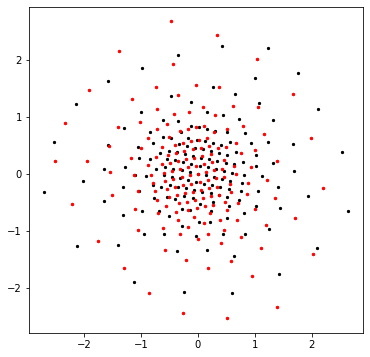

In [36]:
fig, axs = plt.subplots(1, figsize=(8,6))
axs.scatter(xbin_phot, ybin_phot,s=5,c='k',)
axs.scatter(x, y, s=6, c='r')
axs.set_aspect('equal')

In [111]:
xbin_phot = x
ybin_phot = y

# Try a JAM model just to see...

In [176]:
distance = ang_distance

In [177]:
'''
Anisotropy - radial profile for anisotropy
'''
# Try opsikov-merritt in the new method
r_a = 2.5
beta_0 = 0.
beta_inf = 1.0
alpha= 2.0

#beta = [r_a, beta_0, beta_inf, alpha]
# instead try it with the const beta
beta = np.ones_like(surf_density_B)*0.2

'''
What do I do for black hole mass? - According to CF, he thinks it probably doesn't matter
'''
mbh = 0# 1e8 # Black hole mass in solar masses # not sure what to do here

# Below I assume mass follows light, but in a real application one
# will generally include a dark halo in surf_pot, sigma_pot, qobs_pot.
# See e.g. Cappellari (2013) for an example
# https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C
'''
THIS IS WHERE I MAKE THE DIFFERENCE OF TEH SURFACE BRIGHTNESS PROFILE... It was fitting M/L=110-120 ... Let's see now.
'''
surf_lum = surf_pot = fudged_surface_brightness#surf_density_B
sigma_lum = sigma_pot = sigma
qobs_lum = qobs_pot = qObs


# add gaussians to surf_pot and sigma_pot and qobs_pot to get dark matter halo

'''
PSF from the optimization problem
'''
# kinematics sigmapsf
sigmapsf = kcwi_sigmapsf
# kcwi pixel scale
pixsize = kcwi_scale

goodbins = None


####################################################
####################################################
####################################################
Spherical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.51
inc=70.0; beta[1]=0.20; kappa=1.00; M/L=5.19; BH=0.0; chi2/DOF=2.21
Total mass MGE (MSun): 6.963e+11


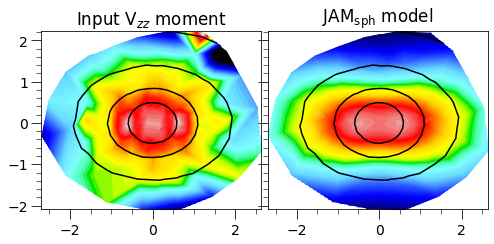

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 3.51
inc=70.0; beta[1]=0.20; kappa=1.15; M/L=1.00; BH=0.0; chi2/DOF=5.81
Total mass MGE (MSun): 1.343e+11


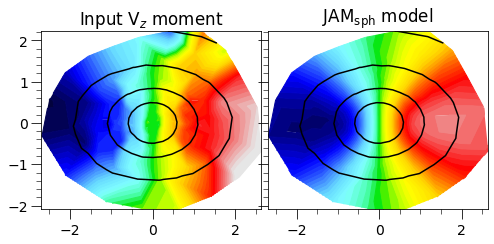

####################################################
####################################################
####################################################
Cylindrical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_cyl_zz (analytic_los=True) elapsed time sec: 0.24
inc=70.0; beta[1]=0.20; kappa=1.00; M/L=5.13; BH=0.0; chi2/DOF=1.53
Total mass MGE (MSun): 6.887e+11


<Figure size 576x432 with 0 Axes>

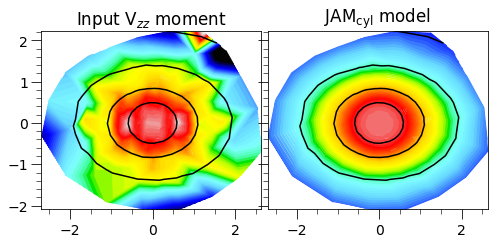

####################################################
####################################################
Modeling moment z
jam_axi_proj_cyl_z (analytic_los=False) elapsed time sec: 0.88
inc=70.0; beta[1]=0.20; kappa=1.52; M/L=1.00; BH=0.0; chi2/DOF=5.72
Total mass MGE (MSun): 1.343e+11


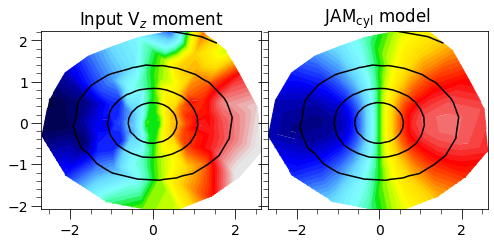

<Figure size 576x432 with 0 Axes>

In [178]:
inc = 70 
#############################################################
# It's time to JAM now!

print('####################################################')
print('####################################################')
print('####################################################')
print(f'Spherical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml


print('####################################################')
print('####################################################')
print('####################################################')
print(f'Cylindrical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml




In [110]:
# This surface brightness is reasonable! Hallelujah!

# So the orientation is already correct for this one. Only replace the surface brightness profile.

In [206]:
surf_density_B

array([1.66256934e+19, 8.87566624e+18, 2.39405825e+18, 6.57092622e+17,
       3.31196554e+17, 7.18313444e+16])

In [207]:
fudged_surface_brightness

array([11496.84830495,  6137.61998833,  1655.51738253,   454.38671302,
         229.02602869,    49.67215791])

# Put this together in one thing

In [215]:
file_m = glob.glob(f'{mos_dir}{obj_name}_mge_fit_sectors_regularized_model.pkl')
if file_m:
    print('mge model exists, loading...')
    with open(file_m[0], 'rb') as file:
        m = pickle.load(file)

    print('################################################')
    print('Regularized MGE fit')
    
paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')

# start with J0037
#obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
#obj_abbr = obj_name[4:9] # e.g. J0029
zlens = paper_table[paper_table['obj_name']==obj_name]['zlens'].to_numpy()[0] #zs[1]
ang_distance = cosmo.angular_diameter_distance(zlens).value
lum_distance = cosmo.luminosity_distance(zlens).value

mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
kin_dir = f'{kinematics_dir}{obj_name}/'
#jam_dir = f'{jam_output_dir}{obj_name}/'
# create a directory for JAM outputs
#Path(jam_dir).mkdir(parents=True, exist_ok=True)

# start with target sn of 15
SN = '15'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
#target_jam_dir = f'{jam_dir}target_sn_{SN}/'
# create a directory for JAM outputs
#Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

# take the surface density, etc from mge saved parameters
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
    tommy_pickles = pickle.load(f)

surf = tommy_pickles.surf_density
sigma = tommy_pickles.mge_sigma
qObs = tommy_pickles.q
kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
Vrms_bin = tommy_pickles.Vrms_bin
dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
V_bin = tommy_pickles.V_bin
dV_bin = tommy_pickles.dV_bin
xbin_phot = tommy_pickles.xbin_phot
ybin_phot = tommy_pickles.ybin_phot
reff = tommy_pickles.reff

axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
pa_phot = axis_info[2]

xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)

scale=0.050 # arcsec/pix

# calculate restrfame correction from DM and redshift
r = lum_distance * 10**6 # distance in pc
DM = 5 * np.log10(r/10)
# slacs ix values
B9 = -22.37
b9 = 18.57 # B band app mag
v9 = 16.9 # V band app mag
# alpha and beta are functions of redshift (from https://iopscience.iop.org/article/10.1086/444585/fulltext/)
a0 = 0.824411
a1 = -3.29360
a2 = 3.40645
alpha = a0 + a1 * zlens /  + a2 * zlens**2   # alpha coeffi
b0 = -0.00169895
b1 = 1.22223
b2 = -8.36258
b3 = 18.9313
beta = b0 + b1 * zlens + b2 * zlens**2 + b3 * zlens**3 # coeff 
# final calculation
restframe_correction = (1 - alpha) * (v9 - b9) + beta - DM

# photometry corrections and zeropoint
zeropoint = 25.793
inf_ap_correction = 0.1
extinctions = pd.read_csv(f'{data_dir}tables/slacs_extinctions.csv')
extinction = extinctions.loc[extinctions.obj_name == obj_name, 'A_B'].values[0]

# counts of Gaussians to apparent magnitude
B_app_mag = - 2.5 * np.log10(total_counts/exp_time) + zeropoint + inf_ap_correction - extinction

# correct to restframe
B_abs_mag = B_app_mag + restframe_correction

# convert to surface magnitudes
B_surf_mag = B_abs_mag + 2.5 * np.log10(2*np.pi*q*sigma_pix**2*scale**2)

# convert to surface brightness in L_sol_B / pc^2
#M_sol_I = 4.08
M_sol_B = 5.45
B_surf_br_arcsec = 10**( 0.4 * (M_sol_B - B_surf_mag)) # L_sol_B / arcsec^2
B_surf_br_pc = I * (206265/(ang_distance*10**6))**2

# calculate total magnitude for fudge factor to scale to slacs ix value
total_appmag_B = zeropoint + inf_ap_correction + 2.5 * np.log10(exp_time) \
                            - 2.5 * np.log10(np.sum(total_counts)) - extinction
total_magnitude_B = total_appmag_B + restframe_correction 
log_fudge_factor = total_magnitude_B - B9
fudged_surface_brightness = B_surf_br_pc * 10**(0.4 * log_fudge_factor)

fudged_surface_brightness



mge model exists, loading...
################################################
Regularized MGE fit


array([11496.84830495,  6137.61998833,  1655.51738253,   454.38671302,
         229.02602869,    49.67215791])

# 05/24/23 - Updating the SN 10 and 20 as well

In [201]:

# now sn 20
SN = '20'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
#target_jam_dir = f'{jam_dir}target_sn_{SN}/'
# create a directory for JAM outputs
#Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

# take the surface density, etc from mge saved parameters
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
    tommy_pickles = pickle.load(f)


surf = tommy_pickles.surf_density
sigma = tommy_pickles.mge_sigma
qObs = tommy_pickles.q
kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
Vrms_bin = tommy_pickles.Vrms_bin
dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
V_bin = tommy_pickles.V_bin
dV_bin = tommy_pickles.dV_bin
xbin_phot = tommy_pickles.xbin_phot
ybin_phot = tommy_pickles.ybin_phot
reff = tommy_pickles.reff


axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
pa_phot = axis_info[2]


xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)


In [50]:
theta = 270 - pa_phot

In [51]:
x, y = rotate_points(xbin_arcsec, ybin_arcsec, theta)

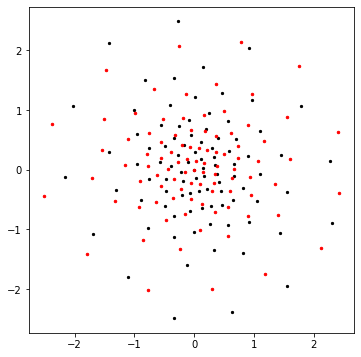

In [52]:

fig, axs = plt.subplots(1, figsize=(8,6))
axs.scatter(xbin_phot, ybin_phot,s=5,c='k',)
axs.scatter(x, y, s=6, c='r')
axs.set_aspect('equal')

In [53]:
xbin_phot = x
ybin_phot = y

####################################################
####################################################
####################################################
Spherical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.57
inc=70.0; beta[1]=0.20; kappa=1.00; M/L=39.9; BH=0.0; chi2/DOF=0.00416
Total mass MGE (MSun): 7.252e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


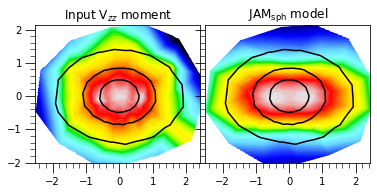

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 3.60
inc=70.0; beta[1]=0.20; kappa=3.26; M/L=1.00; BH=0.0; chi2/DOF=8.08
Total mass MGE (MSun): 1.816e+10


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


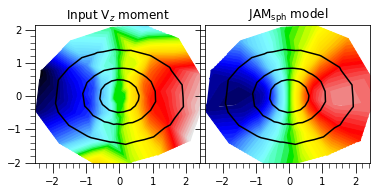

####################################################
####################################################
####################################################
Cylindrical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_cyl_zz (analytic_los=True) elapsed time sec: 0.23
inc=70.0; beta[1]=0.20; kappa=1.00; M/L=39.5; BH=0.0; chi2/DOF=0.00229
Total mass MGE (MSun): 7.168e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


<Figure size 432x288 with 0 Axes>

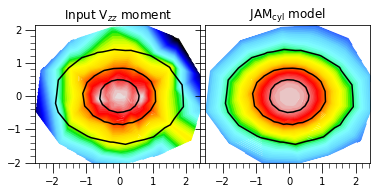

####################################################
####################################################
Modeling moment z
jam_axi_proj_cyl_z (analytic_los=False) elapsed time sec: 0.91
inc=70.0; beta[1]=0.20; kappa=4.30; M/L=1.00; BH=0.0; chi2/DOF=8.07
Total mass MGE (MSun): 1.816e+10


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


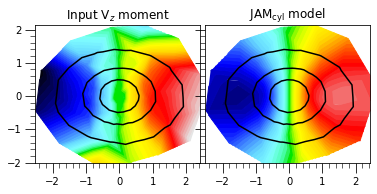

<Figure size 432x288 with 0 Axes>

In [54]:
inc = 70 
#############################################################
# It's time to JAM now!

print('####################################################')
print('####################################################')
print('####################################################')
print(f'Spherical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml


print('####################################################')
print('####################################################')
print('####################################################')
print(f'Cylindrical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml




In [224]:

# now sn 10
SN = '10'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
#target_jam_dir = f'{jam_dir}target_sn_{SN}/'
# create a directory for JAM outputs
#Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

# take the surface density, etc from mge saved parameters
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
    tommy_pickles = pickle.load(f)


surf = tommy_pickles.surf_density
sigma = tommy_pickles.mge_sigma
qObs = tommy_pickles.q
kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
Vrms_bin = tommy_pickles.Vrms_bin
dVrms_bin = tommy_pickles.dVrms_bin # mistake in name
V_bin = tommy_pickles.V_bin
dV_bin = tommy_pickles.dV_bin
xbin_phot = tommy_pickles.xbin_phot
ybin_phot = tommy_pickles.ybin_phot
reff = tommy_pickles.reff


axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
pa_phot = axis_info[2]


xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)


In [225]:
mask10 = dVrms_bin>0

Vrms_bin = Vrms_bin[mask10]
dVrms_bin = dVrms_bin[mask10]
xbin_phot = xbin_phot[mask10]
ybin_phot = ybin_phot[mask10]
V_bin = V_bin[mask10]
dV_bin = dV_bin[mask10]


tommy_pickles.Vrms_bin = Vrms_bin
tommy_pickles.dVrms_bin = dVrms_bin 
tommy_pickles.V_bin = V_bin
tommy_pickles.dV_bin = dV_bin
tommy_pickles.xbin_phot = xbin_phot
tommy_pickles.ybin_phot = ybin_phot

print('dimensions ', Vrms_bin.shape, dVrms_bin.shape, xbin_phot.shape, xbin_phot.shape)

with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'wb') as f:
        pickle.dump(tommy_pickles, f)

dimensions  (304,) (304,) (304,) (304,)


In [226]:
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
        
tommy_pickles.V_bin.shape

(304,)

In [216]:
target_kin_dir

'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2023-02-28_2/SDSSJ0037-0942/target_sn_10/SDSSJ0037-0942_10_marginalized_gnog_final_kinematics/'

In [49]:

# now sn 20
SN = '20'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
#target_jam_dir = f'{jam_dir}target_sn_{SN}/'
# create a directory for JAM outputs
#Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

# take the surface density, etc from mge saved parameters
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
    tommy_pickles = pickle.load(f)


surf = tommy_pickles.surf_density
sigma = tommy_pickles.mge_sigma
qObs = tommy_pickles.q
kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
Vrms_bin = tommy_pickles.Vrms_bin
dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
V_bin = tommy_pickles.V_bin
dV_bin = tommy_pickles.dV_bin
xbin_phot = tommy_pickles.xbin_phot
ybin_phot = tommy_pickles.ybin_phot
reff = tommy_pickles.reff


axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
pa_phot = axis_info[2]


xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)


In [50]:
theta = 270 - pa_phot

In [51]:
x, y = rotate_points(xbin_arcsec, ybin_arcsec, theta)

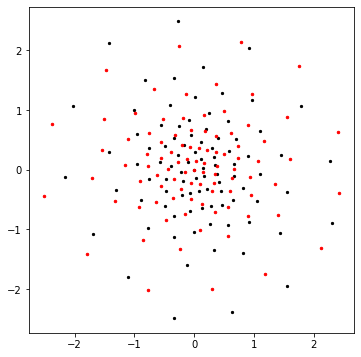

In [52]:

fig, axs = plt.subplots(1, figsize=(8,6))
axs.scatter(xbin_phot, ybin_phot,s=5,c='k',)
axs.scatter(x, y, s=6, c='r')
axs.set_aspect('equal')

In [53]:
xbin_phot = x
ybin_phot = y

####################################################
####################################################
####################################################
Spherical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.57
inc=70.0; beta[1]=0.20; kappa=1.00; M/L=39.9; BH=0.0; chi2/DOF=0.00416
Total mass MGE (MSun): 7.252e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


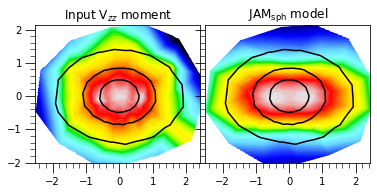

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 3.60
inc=70.0; beta[1]=0.20; kappa=3.26; M/L=1.00; BH=0.0; chi2/DOF=8.08
Total mass MGE (MSun): 1.816e+10


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


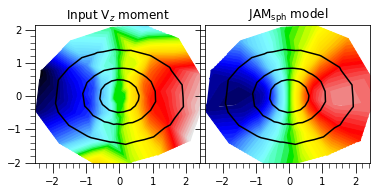

####################################################
####################################################
####################################################
Cylindrical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_cyl_zz (analytic_los=True) elapsed time sec: 0.23
inc=70.0; beta[1]=0.20; kappa=1.00; M/L=39.5; BH=0.0; chi2/DOF=0.00229
Total mass MGE (MSun): 7.168e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


<Figure size 432x288 with 0 Axes>

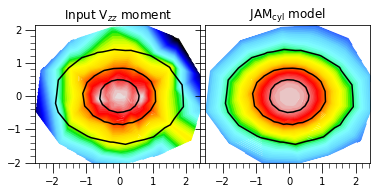

####################################################
####################################################
Modeling moment z
jam_axi_proj_cyl_z (analytic_los=False) elapsed time sec: 0.91
inc=70.0; beta[1]=0.20; kappa=4.30; M/L=1.00; BH=0.0; chi2/DOF=8.07
Total mass MGE (MSun): 1.816e+10


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


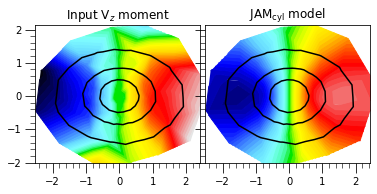

<Figure size 432x288 with 0 Axes>

In [54]:
inc = 70 
#############################################################
# It's time to JAM now!

print('####################################################')
print('####################################################')
print('####################################################')
print(f'Spherical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml


print('####################################################')
print('####################################################')
print('####################################################')
print(f'Cylindrical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml




####################################################
####################################################
####################################################
Spherical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 5.21
inc=70.0; beta[1]=0.20; kappa=1.00; M/L=39.4; BH=0.0; chi2/DOF=2.06
Total mass MGE (MSun): 7.157e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


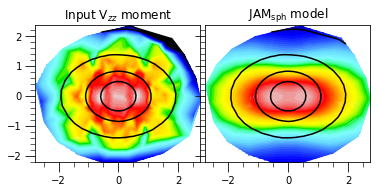

####################################################
####################################################
Modeling moment z
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 5.36
inc=70.0; beta[1]=0.20; kappa=3.31; M/L=1.00; BH=0.0; chi2/DOF=5.00
Total mass MGE (MSun): 1.816e+10


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


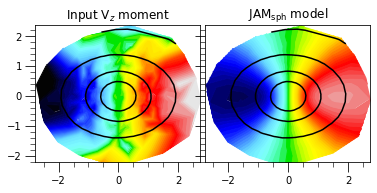

####################################################
####################################################
####################################################
Cylindrical model
####################################################
####################################################
Modeling moment zz
jam_axi_proj_cyl_zz (analytic_los=True) elapsed time sec: 0.22
inc=70.0; beta[1]=0.20; kappa=1.00; M/L=39.0; BH=0.0; chi2/DOF=1.60
Total mass MGE (MSun): 7.079e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


<Figure size 432x288 with 0 Axes>

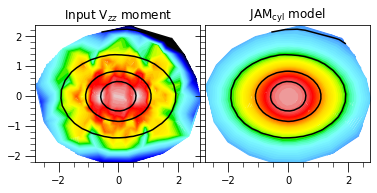

####################################################
####################################################
Modeling moment z
jam_axi_proj_cyl_z (analytic_los=False) elapsed time sec: 0.85
inc=70.0; beta[1]=0.20; kappa=4.36; M/L=1.00; BH=0.0; chi2/DOF=4.96
Total mass MGE (MSun): 1.816e+10


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


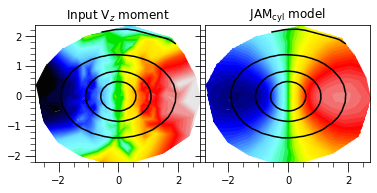

<Figure size 432x288 with 0 Axes>

In [178]:
inc = 70 
#############################################################
# It's time to JAM now!

print('####################################################')
print('####################################################')
print('####################################################')
print(f'Spherical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml


print('####################################################')
print('####################################################')
print('####################################################')
print(f'Cylindrical model')

# I use a loop below, just to higlight the fact that all parameters
# remain the same for the two JAM calls, except for 'moment' and 'data'
plt.figure(1)

#for moment, data, errors in zip(['zz', 'z'], [Vrms_bin, V_bin], [dVrms_bin, dV_bin]):

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=None, nodots=True)

plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

ml = m.ml
#surf_pot = surf_pot*ml

moment = 'z'
data = V_bin
errors = dV_bin

print('####################################################')
print('####################################################')
print(f'Modeling moment {moment}')

inc_rad = np.radians(inc)
qintr_lum = qobs_lum**2 - np.cos(inc_rad)**2
if np.any(qintr_lum <= 0):
    print('This inclination does not work')

# The model is by design similar but not identical to the adopted kinematics!
m = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                 inc, mbh, distance, xbin_phot, ybin_phot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='cyl', ml=ml, nodots=True)
plt.pause(3)
plt.figure(2)
#surf_pot *= m.ml  # Scale the density by the best fitting M/L from the previous step
reduced_chi_squared = m.chi2

#surf_pot = surf_pot*ml




# Fixing my stupid ass dVrms_bin mistake and fixing the bin rotation problem!

In [29]:
def load_kinematics_modified (file_dir, obj_name, vorbin_SN_target, binned_or_2d):
    
    if obj_name == 'SDSSJ0330-0020':
        g_dir = 'no_g'
    else:
        g_dir = 'combinedG'
    
    V = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_{g_dir}_V_{binned_or_2d}.txt', delimiter=',')
    VD = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_{g_dir}_VD_{binned_or_2d}.txt', delimiter=',')
    dV = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_{g_dir}_dV_{binned_or_2d}.txt', delimiter=',')
    dVD = np.genfromtxt(f'{file_dir}{obj_name}_{vorbin_SN_target}_{g_dir}_dVD_{binned_or_2d}.txt', delimiter=',')
    
    return V, dV, VD, dVD

################################################
################################################

Working with S/N target  10

################################################
################################################
find_galaxy model exists, loading...
theta 127.64405601163932
################################################
Get bins


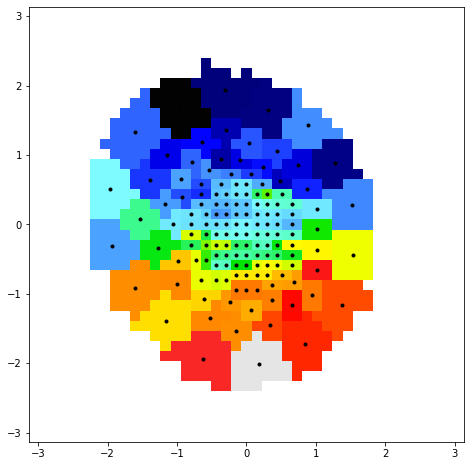

################################################
Correcting barycentre velocity and calculating PA_kin
  Kin PA:   2.0  +/-   8.3  (3*sigma error)
Velocity Offset: 8.65


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


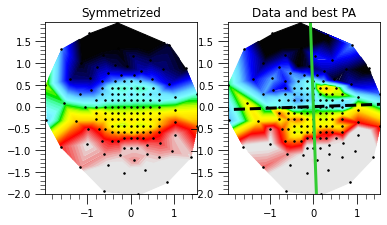

KCWI PA : -45.0
Kinematic PA: -43.0
Photometric PA: -37.64405601163932
################################################
Calculating rms velocity
dimensions  (146,) (146,) (146,) (146,)
################################################
################################################

Working with S/N target  15

################################################
################################################
find_galaxy model exists, loading...
theta 127.64405601163932
################################################
Get bins


<Figure size 432x288 with 0 Axes>

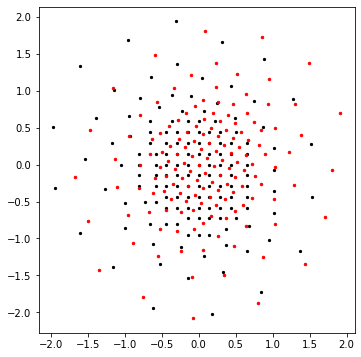

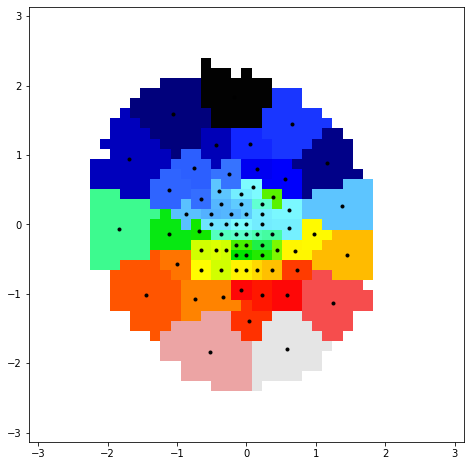

################################################
Correcting barycentre velocity and calculating PA_kin
  Kin PA:   4.5  +/-  11.8  (3*sigma error)
Velocity Offset: 8.15


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


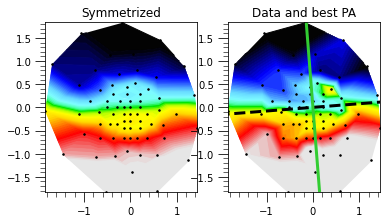

KCWI PA : -45.0
Kinematic PA: -40.5
Photometric PA: -37.64405601163932
################################################
Calculating rms velocity
dimensions  (72,) (72,) (72,) (72,)
################################################
################################################

Working with S/N target  20

################################################
################################################
find_galaxy model exists, loading...
theta 127.64405601163932
################################################
Get bins


<Figure size 432x288 with 0 Axes>

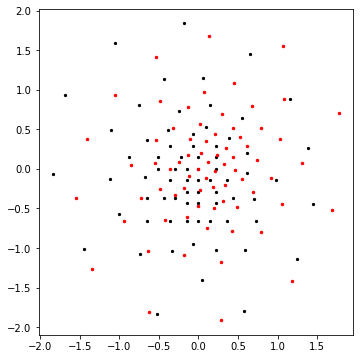

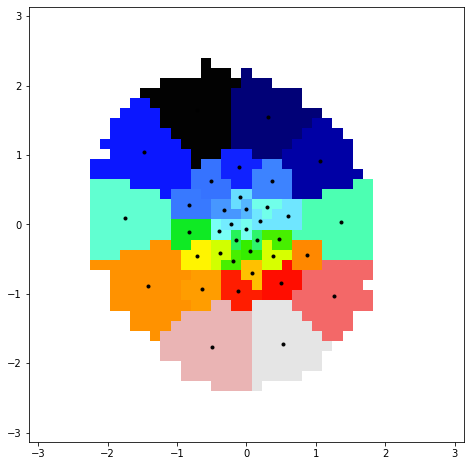

################################################
Correcting barycentre velocity and calculating PA_kin
  Kin PA:   7.0  +/-  19.0  (3*sigma error)
Velocity Offset: 7.34


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


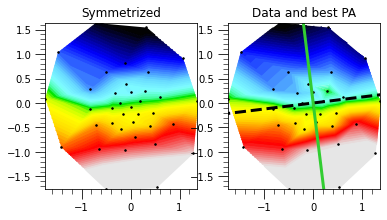

KCWI PA : -45.0
Kinematic PA: -38.0
Photometric PA: -37.64405601163932
################################################
Calculating rms velocity
dimensions  (37,) (37,) (37,) (37,)


<Figure size 432x288 with 0 Axes>

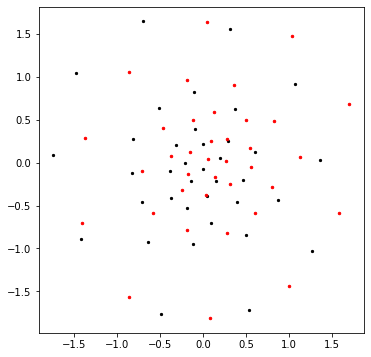

In [30]:
for vorbin_SN_target in vorbin_SN_targets:

    target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
    # create kin_dir if not exists
    #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)

    print('################################################')
    print('################################################')
    print()
    print('Working with S/N target ', vorbin_SN_target)
    print()
    print('################################################')
    print('################################################')

    # point to final kinematics directory for the vorbin sn target
    if obj_abbr == 'J0330':
        # no G
        fin_kin_dir = f'{target_dir}{obj_name}_{vorbin_SN_target}_final_kinematics/no_g/'
    else:
        # marginalized
        fin_kin_dir = f'{target_dir}{obj_name}_{vorbin_SN_target}_marginalized_gnog_final_kinematics/'

    
    file_f = glob.glob(f'{mos_dir}{obj_name}_find_galaxy_model.pkl')
    if file_f:
        print('find_galaxy model exists, loading...')
        with open(file_f[0], 'rb') as file:
            f = pickle.load(file)
        theta = f.theta
    
    print('theta', theta)
    
    # load the kinematics data as 2d maps and bin arrays
    V, dV, VD, dVD = load_kinematics_modified (fin_kin_dir,  obj_name, vorbin_SN_target, '2d')
    V_bin, dV_bin, VD_bin, dVD_bin = load_kinematics_modified (fin_kin_dir, obj_name, vorbin_SN_target, 'binned_masked')
    
    # remove pixels that have VD > 350 and VD < 50, etc?

    ################################################
    # bin velocity maps

    print('################################################')
    print('Get bins')

    xbin_arcsec, ybin_arcsec = get_bins (target_dir, obj_name)

    # Check binning

    # plot with arcsec
    width =  V.shape[0]/2 * kcwi_scale
    extent = [-width,width,-width,width]
    plt.figure(figsize=(8,8))
    plt.imshow(V, origin='lower', extent=extent, cmap='sauron')
    plt.scatter(xbin_arcsec, ybin_arcsec, color='k', marker='.')
    plt.pause(1)
    plt.clf()

    ##################################################
    # correct barycenter velocity and PA

    print('################################################')
    print('Correcting barycentre velocity and calculating PA_kin')

    # kinematic PA is measured from the kinematic map's N thru E (ie. "counter clockwise of up", if KCWI aperture position angle was not set to 0, this will not be really north)
    PA_kin_, dPA_kin, velocity_offset = fit_kinematic_pa(xbin_arcsec, ybin_arcsec, V_bin)#, debug=debug)
    # convert to N thru E
    PA_kin = PA_kin_ + kcwi_pa
    dPA_kin = dPA_kin / 3 # errors are 3 sigma, make 1 sigma

    plt.pause(1)
    plt.clf()

    # Correct the velocity
    V = V - velocity_offset
    V_bin = V_bin - velocity_offset

    # PA_phot is theta from find_galaxy, measured from negative x-axis
    # convert to N thru E (this will be true north because HST images are oriented that way [I think...])
    PA_phot = 90 - theta

    ##################################################
    # rotate the bins by the kinematics PA and the photometric PA
    # plot the rotation with the "non-symmetrized velocity field"

    # both kinematic and photometric PA should be less than 180
    print(f'KCWI PA : {kcwi_pa}') # PA of KCWI aperture relative to N
    print(f'Kinematic PA: {PA_kin}')
    print(f'Photometric PA: {PA_phot}') # PA from photometry
    
    x, y = rotate_points(xbin_arcsec, ybin_arcsec, theta)

    fig, axs = plt.subplots(1, figsize=(8,6))
    axs.scatter(xbin_arcsec, ybin_arcsec,s=5,c='k',)
    axs.scatter(x, y, s=6, c='r')
    axs.set_aspect('equal')

    #######################################
    # rms velocity
    print('################################################')
    print('Calculating rms velocity')
    Vrms_bin = np.sqrt(V_bin**2 + VD_bin**2)
    dVrms_bin = np.sqrt((dV_bin*V_bin)**2 + (dVD_bin*VD_bin)**2)/Vrms_bin
    
    ########################################
    # update the pickle
    # take the surface density, etc from mge saved parameters
    with open(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
    
    tommy_pickles.Vrms_bin = Vrms_bin
    tommy_pickles.dVrms_bin = dVrms_bin # mistake in name
    tommy_pickles.V_bin = V_bin
    tommy_pickles.dV_bin = dV_bin # mistake in name
    tommy_pickles.xbin_phot = x
    tommy_pickles.ybin_phot = y
    
    print('dimensions ', Vrms_bin.shape, dVrms_bin.shape, x.shape, y.shape)
    
   # with open(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_details_for_jampy.pkl', 'wb') as f:
   #         pickle.dump(tommy_pickles, f)


# Check the pickles...

################################################
################################################

Working with S/N target  10

################################################
################################################
[290.67360263 295.40018502 293.82827712 287.94112992 278.22878845]
[6.67415548 6.79130518 5.86308968 5.65216633 6.05556696]
[-12.59888159 -15.00873743 -10.42962339  -8.76066423   9.35478357]
[6.13988002 6.23027966 5.3854354  5.20900785 5.60185353]
[0.03040478 0.17289702 0.14249224 0.         0.28498449]
[ 0.14249224  0.11208746 -0.03040478  0.         -0.06080956]

(304,)
(304,)
(304,)
(304,)
(304,)
(304,)

[1459.97193051  779.40950993  210.23230409   57.70206138   29.08375969
    6.30781188]
[0.019      0.16525636 0.43856205 0.89301246 1.7218511  4.94193347]
[0.7 0.7 0.7 0.7 0.7 0.8]

2.154388389566184
################################################
################################################

Working with S/N target  15

###################################

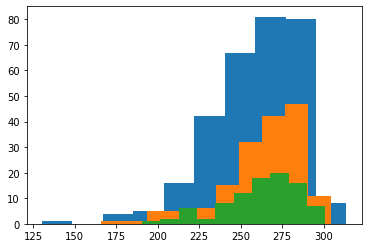

In [3]:
obj_names_index=1
obj_name = obj_names[obj_names_index]
obj_abbr = obj_name[4:9] # e.g. J0029

#mos_dir = f'{mosaics_dir}{obj_name}/' 
kin_dir = f'{kinematics_dir}{obj_name}/'

for vorbin_SN_target in vorbin_SN_targets:

    target_dir = f'{kin_dir}target_sn_{vorbin_SN_target}/'
    # create kin_dir if not exists
    #Path(f'{target_dir}').mkdir(parents=True, exist_ok=True)

    print('################################################')
    print('################################################')
    print()
    print('Working with S/N target ', vorbin_SN_target)
    print()
    print('################################################')
    print('################################################')

    # point to final kinematics directory for the vorbin sn target
    if obj_abbr == 'J0330':
        # no G
        fin_kin_dir = f'{target_dir}{obj_name}_{vorbin_SN_target}_final_kinematics/no_g/'
    else:
        # marginalized
        fin_kin_dir = f'{target_dir}{obj_name}_{vorbin_SN_target}_marginalized_gnog_final_kinematics/'
        

    with open(f'{fin_kin_dir}{obj_name}_{vorbin_SN_target}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
        
        print(tommy_pickles.Vrms_bin[:5])
        print(tommy_pickles.dVrms_bin[:5])
        print(tommy_pickles.V_bin[:5])
        print(tommy_pickles.dV_bin[:5])
        print(tommy_pickles.xbin_phot[:5])
        print(tommy_pickles.ybin_phot[:5]) 
        print()
        print(tommy_pickles.Vrms_bin.shape)
        print(tommy_pickles.dVrms_bin.shape)
        print(tommy_pickles.V_bin.shape)
        print(tommy_pickles.dV_bin.shape)
        print(tommy_pickles.xbin_phot.shape)
        print(tommy_pickles.ybin_phot.shape) 
        print()
        
        print(tommy_pickles.surf_density)
        print(tommy_pickles.mge_sigma)
        print(tommy_pickles.q)
        
        print()
        print(tommy_pickles.reff)
        
        plt.hist(tommy_pickles.Vrms_bin)